In [1]:
import numpy as np #para manejo de vectores
import matplotlib.pyplot as plt #para gráficas
import math # para operaciones matemáticas
import random #para números aleatorios
import pandas as pd

Valores iniciales:
Los vectores son de dimensión $dim = 10$

El dominio de cada coordenada es $[xmin,xmax] = [-10,10]$

La población inicial es de 100 individuos

Se generan vectores de manera aleatoria uniforme, considerando el artículo de Ono acerca de UNDX, el valor de la varianza para el eje principal es 
$$\sigma^2_\xi=\frac{1}{4}$$ 
y para el espacio ortogonal: 
$$\sigma^2_\eta=\frac{2}{3(n-1)} =  \frac{2}{27}$$ 

pues $n=dim =10$. 

Este es un algoritmo genético que sigue la propuesta de Ono: 
* Generar de manera aleatoria vectores de dimensión 10
* Elegir dos individuos de manera aleatoria sin reemplazo
* Generar decendencia aplicando UNDX a los individuos elegidos, se repite este proceso $n_c$ veces para crear $2\times n_c$ decendientes
* Sobreviven dos individuos de la familia que contiene a los padres y su decendencia; uno es el mejor individuo y el otro es elegido mediante ruleta. Los elementos reemplazan a los padres en la población
* Se repiten los pasos anteriores hasta algún criterio de paro



In [2]:
dim = 10
xmin = -10
xmax = 10

vareta = 0.074
varxi = 0.25

pobsize = 100
n_c = 50
pob_mut = 0.09
maxiter = 1000

In [3]:
########### Norma de un vector para ahorrar notación #################
def norma(v):
    return np.linalg.norm(v)

In [4]:
############ Generar vectores n dimensionales de manera aleatoria uniforme ##############
def create_pob(pobsize):
    pob = []
    for i in range(pobsize):
        vector = []
        for j in range(dim):
            x = random.uniform(-10,10)
            vector.append(x)            
        vector = np.array(vector)
        pob.append(vector)
    return pob           

In [5]:
########## Función fitness a optimizar, hallar mínimo en este caso ###########
def aptitud(x):
    return np.sum(x**2)

In [6]:
##############################################################
# Calcula el complemento ortogonal de un vector              #
# El resultado es una base de n-1 elementos de dimension n   #
##############################################################
def orthogonal_vectors(base_vector, num_vectors = dim -1):
    vectors = []
    while len(vectors) < num_vectors:
        vec = np.random.rand(dim)
        for v in vectors + [base_vector]:
            epsilon = 1e-8  #np batalla para dividir entre números pequeños
            vec -= np.dot(vec, v) / (np.dot(v, v) + epsilon) * v #sumo un número pequeño para evitar errores
        if norma(vec) > 1e-5:  
            vectors.append(vec / norma(vec))  
    return np.array(vectors)

In [7]:
##############################################
# Genera el elemento del espacio ortogonal   #
# usando la varianza teorica                 #
##############################################

def gen_corth(base):
    vect = 0
    for i in base:
        etai = np.random.normal(0,np.sqrt(vareta))
        vect += etai * i
    return vect

In [8]:
def mut_uniform(childs, prob_mut):
    for child in childs:
        for i in range(len(child)):
            if np.random.rand() < prob_mut:
                child[i] = np.random.uniform(xmin,xmax)
    return childs
          

In [9]:
###############################################################
# Segun ono sobrevive el mejor y el que gane                  #
# ruleta, la ruleta esta basada en la aptitud                 #
# como se intenta minimizar tomo el inverso multiplicativo    #
# para que la menor aptitud tenga mayor probabilidad          #
# de ser elegida                                              #
###############################################################
def survival_selection(family):
    best = min(family, key=lambda individual: aptitud(individual))
    weights = [1.0 / (aptitud(ind) + 1e-6) for ind in family]  
    roulette_selection = random.choices(family, weights=weights, k=1)[0]
    return best, roulette_selection


In [10]:
#################################################################
# Operador undx, recibe a la población y arroja a la población  #
# con el reemplazo hecho por la ruleta  y el mejor              #
#################################################################
def undx(pob, n_c,pob_mut):
    epsilon = 1e-8
    padres = random.sample(pob, 3)
    x1, x2, x3 = padres
    xp = 0.5 * (x2 + x1)
    d = x2 - x1
    offspring = []

    for _ in range(n_c):
        x31 = x3 - x1
        x21 = x2 - x1
        D = math.sqrt(norma(x31)**2 * (1 - (np.dot(x31, x21) / (norma(x31) * norma(x21) + epsilon))**2))
        orth_vects = orthogonal_vectors(d, num_vectors=dim-1)
        comp_orth = gen_corth(orth_vects)
        xi = np.random.normal(0, np.sqrt(varxi))
        x_c = xp + xi * d + comp_orth
        x_c2 = xp - xi * d - comp_orth
        offspring.extend([x_c, x_c2])
        
        
    offspring = mut_uniform(offspring,pob_mut)

    family = [x1, x2, x3] + offspring
    best, roulette = survival_selection(family)

    for idx in range(len(pob)):
        if np.array_equal(pob[idx], x1):
            pob[idx] = best
            break

    for idx in range(len(pob)):
        if np.array_equal(pob[idx], x2):
            pob[idx] = roulette
            break

    sorted_pob = sorted(pob, key=lambda individual: aptitud(individual))

    return sorted_pob

In [11]:
# inpob = create_pob(pobsize)
# x = np.array([arr[0] for arr in inpob])
# y = np.array([arr[1] for arr in inpob])
# z = np.array([arr[2] for arr in inpob])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')


# scatter = ax.scatter(x, y, z, alpha =0.8)

# ax.set_xlabel('X Coordinate')
# ax.set_ylabel('Y Coordinate')
# ax.set_zlabel('Z Coordinate')

# plt.show()

In [12]:
def alg_gen(maxiter, pobsize):
    inpob = create_pob(pobsize)
    lista = []
    for i in range(maxiter):
        inpob = undx(inpob, n_c, pob_mut)
        #print(f"generación {i+1} tiene como mejor aptitud {aptitud(inpob[0])}")
        lista.append(aptitud(inpob[0]))
    best = aptitud(lista[-1])
    return inpob, lista
    

In [13]:
# alg_gen(maxiter,pobsize)

In [14]:
x = {}
for i in range(30):
    x[i] = alg_gen(maxiter,pobsize)
    print(f" terminé la ejecución {i}")

 terminé la ejecución 0
 terminé la ejecución 1
 terminé la ejecución 2
 terminé la ejecución 3
 terminé la ejecución 4
 terminé la ejecución 5
 terminé la ejecución 6
 terminé la ejecución 7
 terminé la ejecución 8
 terminé la ejecución 9
 terminé la ejecución 10
 terminé la ejecución 11
 terminé la ejecución 12
 terminé la ejecución 13
 terminé la ejecución 14
 terminé la ejecución 15
 terminé la ejecución 16
 terminé la ejecución 17
 terminé la ejecución 18
 terminé la ejecución 19
 terminé la ejecución 20
 terminé la ejecución 21
 terminé la ejecución 22
 terminé la ejecución 23
 terminé la ejecución 24
 terminé la ejecución 25
 terminé la ejecución 26
 terminé la ejecución 27
 terminé la ejecución 28
 terminé la ejecución 29


In [15]:
mejor_vector = []
mejores_aptitudes = []
graficas = []
for i in range(30):
    mejores_aptitudes.append(aptitud(x[i][0][0]))
    mejor_vector.append(x[i][0][0])
    graficas.append(x[i][1])

In [16]:
df = pd.DataFrame(mejor_vector)
df['mejores_aptitudes'] = mejores_aptitudes

# Exportar el DataFrame a un archivo CSV
df.to_csv('real_1.csv', index=False)

In [20]:
df = df.sort_values(by='mejores_aptitudes')

In [30]:
df

,0,1,2,3,4,5,6,7,8,9,mejores_aptitudes
13,-0.083655,0.035219,-0.019565,0.013930,-0.111978,0.029889,-0.052664,0.017954,-0.012262,-0.024554,0.026097
24,0.068141,-0.047920,-0.017605,0.044279,0.095381,-0.026901,0.066266,-0.040772,-0.064017,0.046943,0.031387
9,-0.107095,0.011257,0.064244,0.027230,-0.027125,0.027099,-0.055897,-0.005144,-0.107607,-0.071530,0.037782
7,-0.085815,-0.036286,0.032855,-0.110361,-0.063114,-0.043742,-0.052074,0.022278,0.084647,0.013412,0.038390
18,0.044858,-0.115721,-0.032690,0.039557,-0.063544,0.032883,0.084283,0.056169,-0.046213,0.054725,0.038545
10,0.140054,0.116604,0.003461,-0.075826,-0.016409,-0.047799,0.012026,-0.013508,0.036751,0.071512,0.048319
11,0.018378,-0.148769,0.051739,-0.035396,0.063817,0.072455,0.055283,0.071924,-0.052529,-0.044778,0.048716
16,0.068624,-0.040732,-0.148830,0.065730,-0.022826,0.066399,0.063203,0.010412,0.078674,-0.025714,0.048723
27,-0.015418,-0.026308,0.029180,-0.103939,0.094957,0.079895,0.022999,0.066846,0.112706,0.067388,0.050226
22,-0.067680,0.112676,0.017670,0.106724,-0.017552,-0.035577,0.072973,0.028193,0.119435,0.009992,0.051037


In [32]:
#df.to_csv('undx_1_ejecuciones.csv', index=False)
df.to_csv('undx_1_ejecuciones.csv', index=True, index_label='mi_indice')

<IPython.core.display.Javascript object>


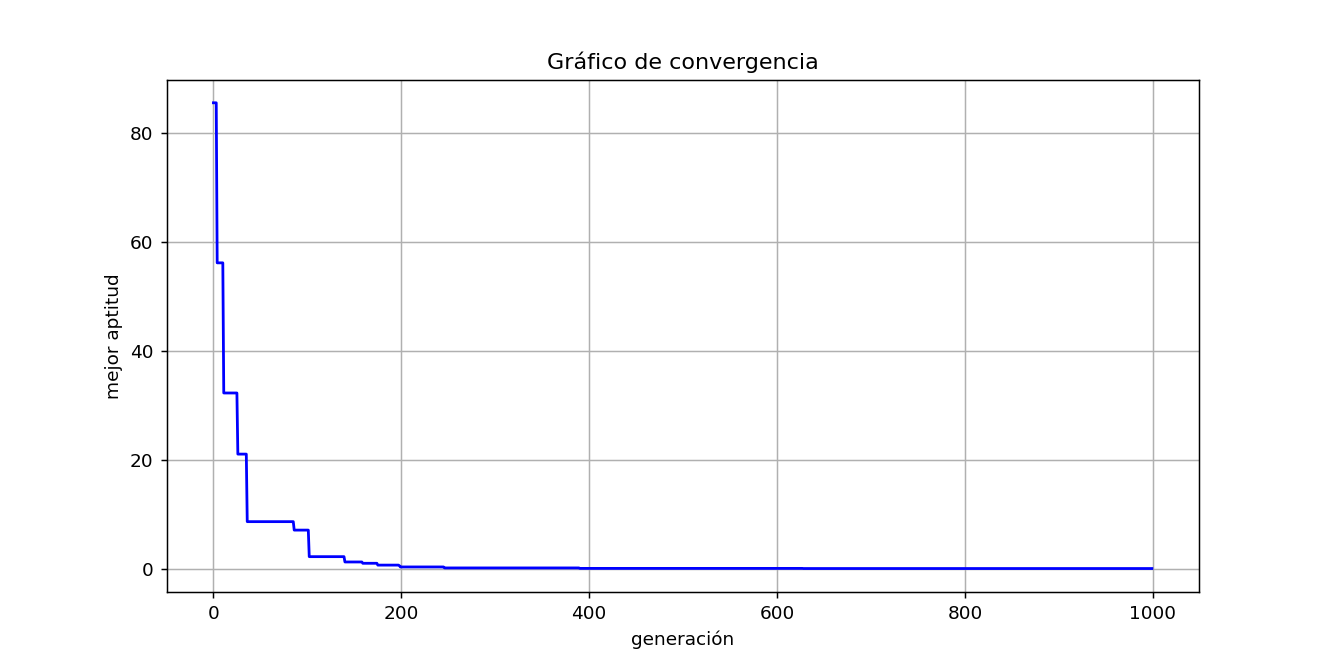

In [22]:
plt.figure(figsize=(10, 5))  # Crea una figura con un tamaño específico
plt.plot(graficas[0],  linestyle='-', color='b')
plt.title('Gráfico de convergencia')  
plt.xlabel('generación')  
plt.ylabel('mejor aptitud')  
plt.grid(True)

plt.show()

In [28]:
import csv

# Guardar la lista en un archivo CSV
with open('mediana_undx_1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(graficas[0])

<IPython.core.display.Javascript object>


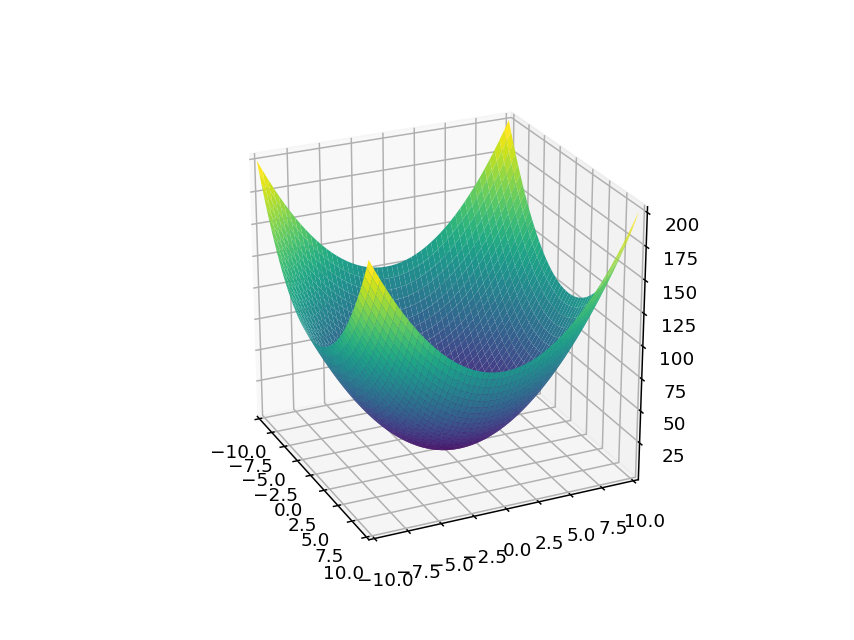

In [19]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D


def funcion(x, y):
    return x**2 + y**2


x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(x, y)
Z = funcion(X, Y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')


ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([np.min(Z), np.max(Z)])


ax.set_box_aspect([1,1,1])  


plt.show()


In [26]:
print(x[0])

-10.0
